# **Libraries**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pickle
from keras.models import save_model

# **Prepare date for training**

In [2]:
df = pd.read_csv('data.csv')

In [2]:
def split_date(df):
    df[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = df['Date'].str.extract(r'(\d+)-(\d+)-(\d+) (\d+):(\d+):(\d+)')
    return df

In [4]:
df = split_date(df)

**Predict missing values**

In [5]:
def predict_missing_values(df, model):
    """
    Function for predicting missing values in DataFrame.
    """

    date_column = df['Date']
    df.drop('Date', axis=1, inplace=True)

    columns_with_missing = df.columns[df.isnull().any()].tolist()

    for column_name in columns_with_missing:
        df_tmp = df.copy()

        for column_name_2 in columns_with_missing:
            if column_name != column_name_2:
                df_tmp.drop(column_name_2, axis=1, inplace=True)

        test_data = df_tmp[df_tmp[column_name].isnull()]

        df_tmp.dropna(inplace=True)

        X_train = df_tmp.drop(column_name, axis=1)
        y_train = df_tmp[column_name]

        model.fit(X_train, y_train)

        X_test = test_data.drop(column_name, axis=1)
        y_pred = model.predict(X_test)

        df.loc[test_data.index, column_name] = y_pred

    df['Date'] = date_column
    return df

In [6]:
df = predict_missing_values(df, RandomForestRegressor())

**Sort by date**

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

# **Create New Features**

**Weather Data**

In [8]:
from Utils.WeatherService import create_weather_features

df = create_weather_features(df)

In [19]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

In [22]:
df['Month'] = df['Month'].astype(int)
df['Season'] = df['Month'].apply(get_season)
dummies = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, dummies], axis=1)
df.drop('Season', axis=1, inplace=True)
df.drop('Season_Unknown', axis=1, inplace=True)

**Air Data (O3, SO2, CO2)**

In [7]:
df.to_csv('data_with_weather_and_air.csv', index=False)

In [7]:
def show_mutual_info_scores(df):
    X = df.drop('PM10', axis=1)
    y = df['PM10']

    mutual_info_scores = mutual_info_regression(X, y)
 
    scores_dict = {column: score for column, score in zip(X.columns, mutual_info_scores)}

    sorted_scores = dict(sorted(scores_dict.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_scores.keys()), list(sorted_scores.values()), color=np.random.rand(3,), alpha=0.7, edgecolor='black')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.title('Histogram of Mutual Information Scores')

    plt.show()

**Pollution Ratio (_NO2 / PM2.5_)**

In [4]:
df['NO2_PM2.5'] = df['NO2'] / df['PM2.5']

**Pollution Ratio _(O3 / NO2)_**

In [31]:
df['O3_NO2'] = df['O3'] / df['NO2']

**Pollution Ration _(SO2 / CO2)_**

In [33]:
df['SO2_CO2'] = df['SO2'] / df['CO2']

**TMP**

In [2]:
df = pd.read_csv('data_with_weather_and_air.csv')

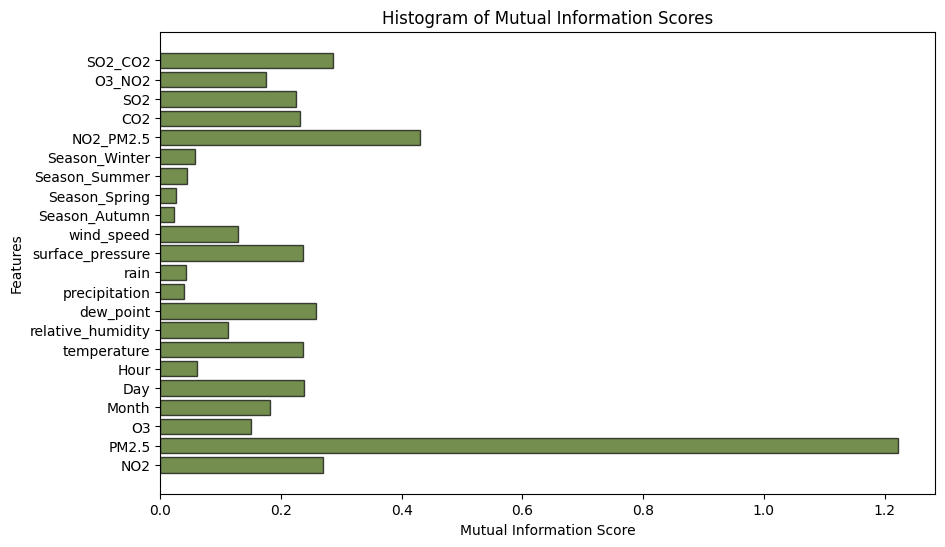

In [53]:
df_copy = df.copy()
df_copy.drop(['Date'], axis=1, inplace=True)
show_mutual_info_scores(df_copy)

# **Remove Low Value Features**

In [9]:
df.drop(['Latitude'], axis=1, inplace=True)
df.drop(['Longitude'], axis=1, inplace=True)
df.drop(['Altitude'], axis=1, inplace=True)
df.drop(['Year'], axis=1, inplace=True)
df.drop(['Minute'], axis=1, inplace=True)
df.drop(['Second'], axis=1, inplace=True)
df.drop(['snowfall'], axis=1, inplace=True)

# **Feature Transformation & Scaling**

In [11]:
def show_compare_histograms(data1, data2, data3=None, title1="", title2="", title3="", figsize=(8,6)):
    if data3 is not None:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    else :
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    axs[0].hist(data1, color=np.random.rand(3,), edgecolor="black")
    axs[0].set_title(title1)

    axs[1].hist(data2, color=np.random.rand(3,), edgecolor="black")
    axs[1].set_title(title2)

    if data3 is not None:
        axs[2].hist(data3, color=np.random.rand(3,), edgecolor="black")
        axs[2].set_title(title3)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    plt.show()

**NO2**

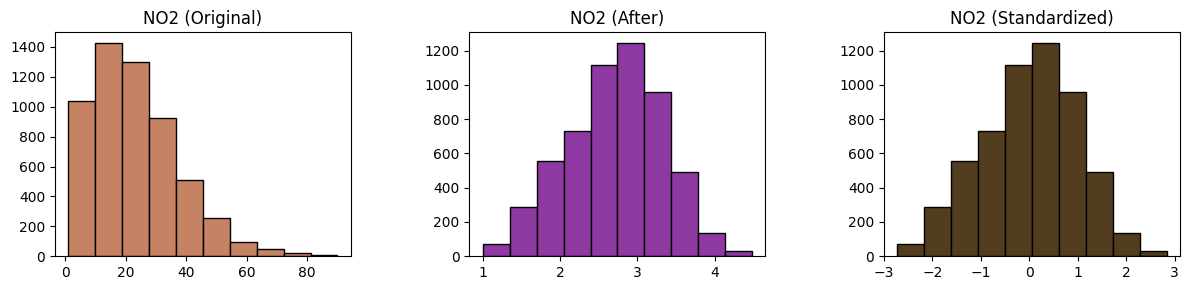

In [12]:
no2 = df['NO2'].copy()

no2_cbrt = np.cbrt(no2)

scaler = StandardScaler()
standardized_no2 = scaler.fit_transform(no2_cbrt.values.reshape(-1, 1))

with open('Scalers/scaler_no2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['NO2'],
    no2_cbrt,
    standardized_no2,
    'NO2 (Original)',
    'NO2 (After)',
    'NO2 (Standardized)'
)

df['NO2'] = standardized_no2

**PM2.5**

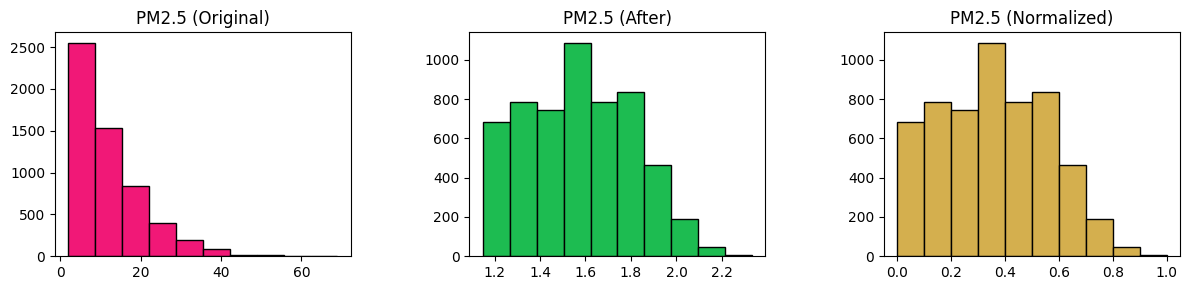

In [13]:
pm25 = df['PM2.5'].copy()

pm25 = pm25 ** (1/5) # peti koren

scaler = MinMaxScaler()
normalized_pm25 = scaler.fit_transform(pm25.values.reshape(-1, 1))

with open('Scalers/scaler_pm25.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['PM2.5'],
    pm25,
    normalized_pm25,
    'PM2.5 (Original)',
    'PM2.5 (After)',
    'PM2.5 (Normalized)'
)

df['PM2.5'] = normalized_pm25

**PM10**

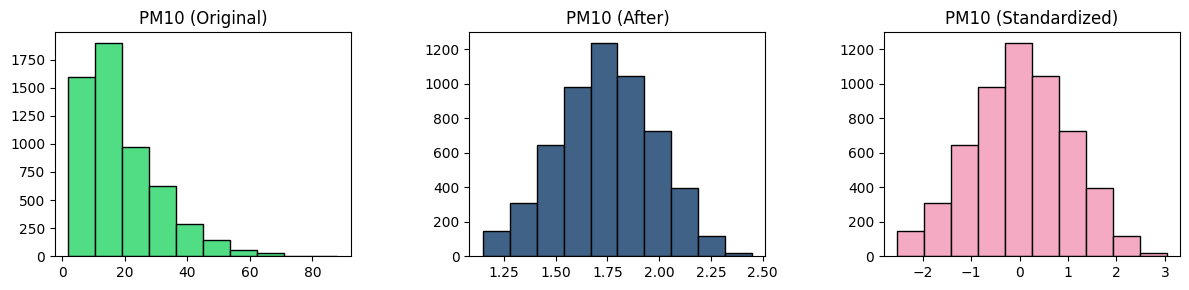

In [14]:
pm10 = df['PM10'].copy()

pm10 = pm10 ** (1/5) # peti koren

scaler = StandardScaler()
standardized_pm10 = scaler.fit_transform(pm10.values.reshape(-1, 1))

with open('Scalers/scaler_pm10.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
     df['PM10'],
     pm10,
     standardized_pm10,
    'PM10 (Original)',
    'PM10 (After)',
    'PM10 (Standardized)'
)

df['PM10'] = standardized_pm10

**Month**

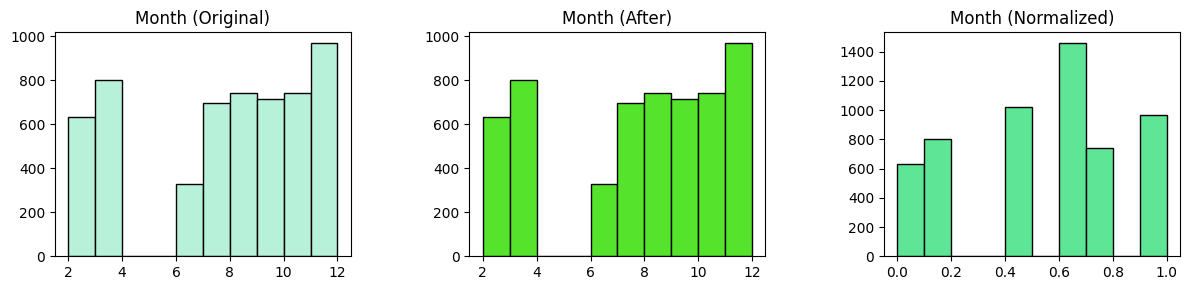

In [15]:
month = df['Month'].copy()
scaler = MinMaxScaler()
normalized_month = scaler.fit_transform(month.values.reshape(-1, 1))

with open('Scalers/scaler_month.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['Month'],
    month,
    normalized_month,
    'Month (Original)',
    'Month (After)',
    'Month (Normalized)'
)

df['Month'] = normalized_month

**Day**

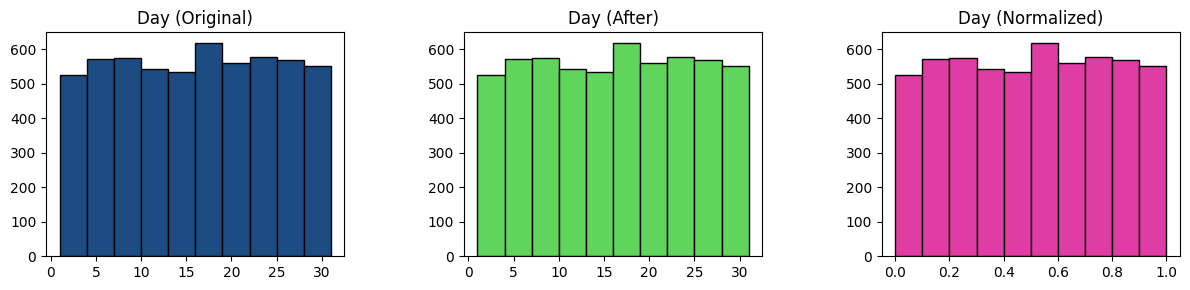

In [16]:
day = df['Day'].copy()

scaler = MinMaxScaler()
normalized_day = scaler.fit_transform(day.values.reshape(-1, 1))

with open('Scalers/scaler_day.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['Day'],
    day,
    normalized_day,
    'Day (Original)',
    'Day (After)',
    'Day (Normalized)'
)

df['Day'] = normalized_day

**Hour**

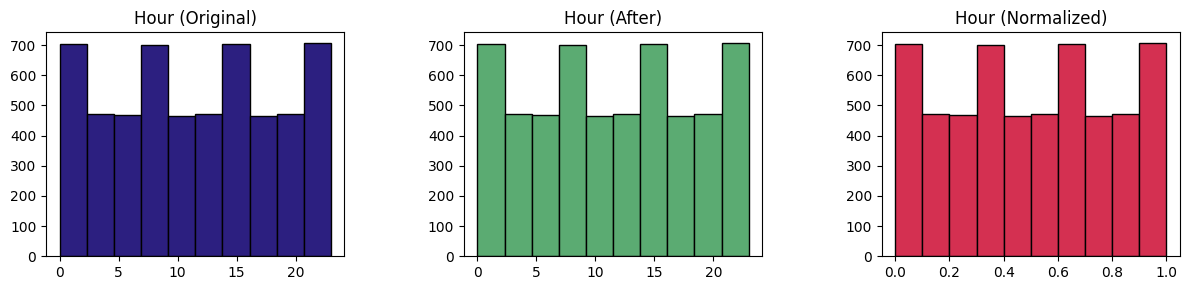

In [17]:
hour = df['Hour'].copy()

scaler = MinMaxScaler()
normalized_hour = scaler.fit_transform(hour.values.reshape(-1, 1))

with open('Scalers/scaler_hour.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['Hour'],
    hour,
    normalized_hour,
    'Hour (Original)',
    'Hour (After)',
    'Hour (Normalized)'
)

df['Hour'] = normalized_hour

**Temperature**

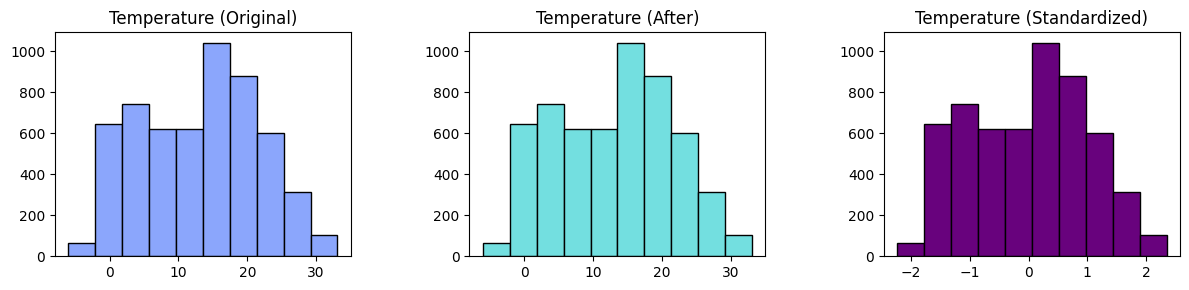

In [18]:
temperature = df['temperature'].copy()

scaler = StandardScaler()
standardized_temperature = scaler.fit_transform(temperature.values.reshape(-1, 1))

with open('Scalers/scaler_temperature.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['temperature'],
    temperature,
    standardized_temperature,
    'Temperature (Original)',
    'Temperature (After)',
    'Temperature (Standardized)'
)

df['temperature'] = standardized_temperature

**Relative Humidity**

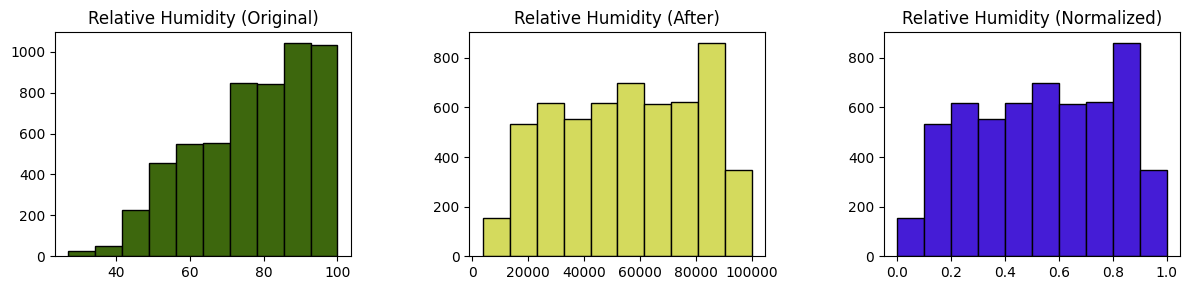

In [19]:
relative_humidity = df['relative_humidity'].copy()

relative_humidity = relative_humidity ** 2.5

scaler = MinMaxScaler()
normalized_relative_humidity = scaler.fit_transform(relative_humidity.values.reshape(-1, 1))

with open('Scalers/scaler_relative_humidity.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['relative_humidity'],
    relative_humidity,
    normalized_relative_humidity,
    'Relative Humidity (Original)',
    'Relative Humidity (After)',
    'Relative Humidity (Normalized)'
)

df['relative_humidity'] = normalized_relative_humidity

**Dew Point**

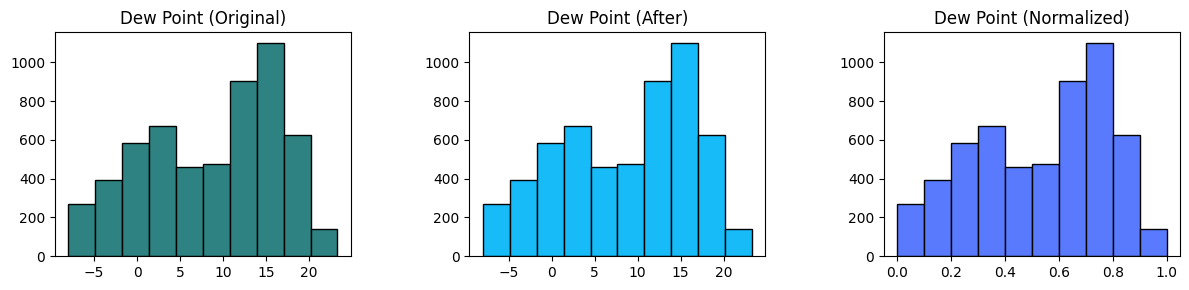

In [20]:
dew_point = df['dew_point'].copy()

scaler = MinMaxScaler()
normalized_dew_point = scaler.fit_transform(dew_point.values.reshape(-1, 1))

with open('Scalers/scaler_dew_point.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['dew_point'],
    dew_point,
    normalized_dew_point,
    'Dew Point (Original)',
    'Dew Point (After)',
    'Dew Point (Normalized)'
)

df['dew_point'] = normalized_dew_point

**Precipitation**

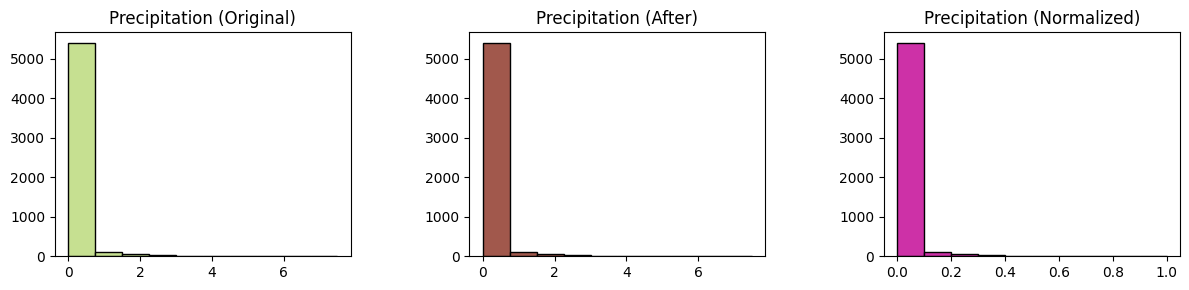

In [21]:
precipitation = df['precipitation'].copy()

scaler = MinMaxScaler()
normalized_precipitation = scaler.fit_transform(precipitation.values.reshape(-1, 1))

with open('Scalers/scaler_precipitation.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['precipitation'],
    precipitation,
    normalized_precipitation,
    'Precipitation (Original)',
    'Precipitation (After)',
    'Precipitation (Normalized)'
)

df['precipitation'] = normalized_precipitation

**Rain**

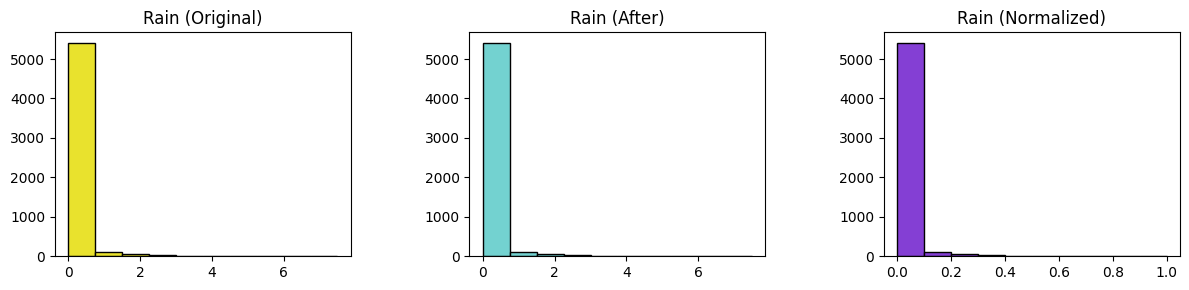

In [22]:
rain = df['rain'].copy()

scaler = MinMaxScaler()
normalized_rain = scaler.fit_transform(rain.values.reshape(-1, 1))

with open('Scalers/scaler_rain.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['rain'],
    rain,
    normalized_rain,
    'Rain (Original)',
    'Rain (After)',
    'Rain (Normalized)'
)

df['rain'] = normalized_rain

**Surface Pressure**

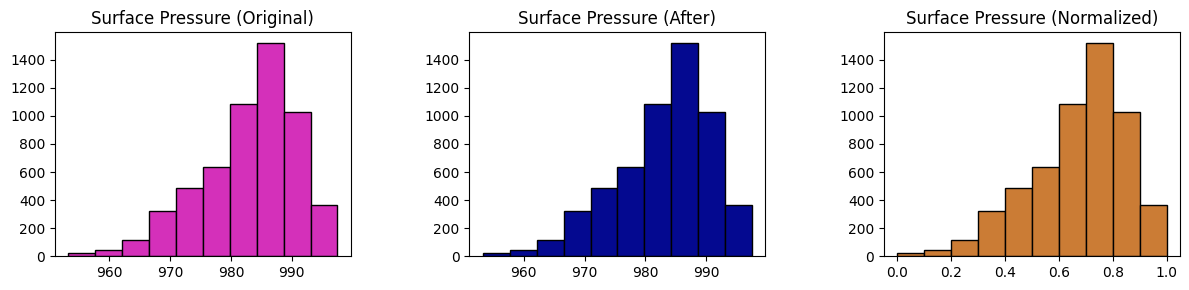

In [23]:
surface_pressure = df['surface_pressure'].copy()

scaler = MinMaxScaler()
normalized_surface_pressure = scaler.fit_transform(surface_pressure.values.reshape(-1, 1))

with open('Scalers/scaler_surface_pressure.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['surface_pressure'],
    surface_pressure,
    normalized_surface_pressure,
    'Surface Pressure (Original)',
    'Surface Pressure (After)',
    'Surface Pressure (Normalized)'
)

df['surface_pressure'] = normalized_surface_pressure

**Wind Speed**

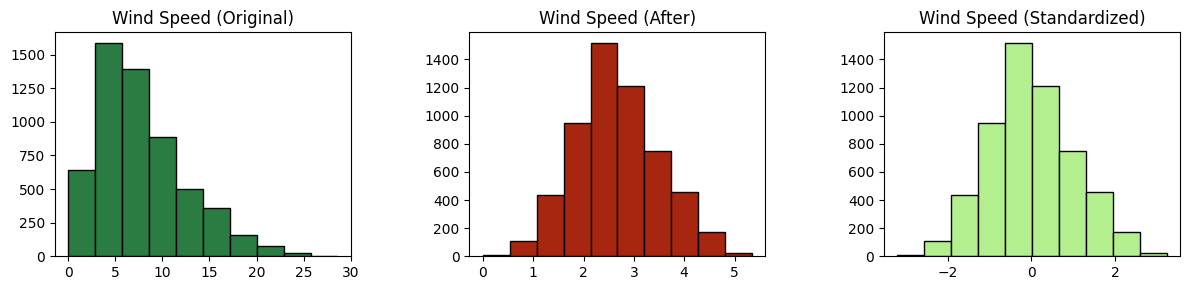

In [24]:
wind_speed = df['wind_speed'].copy()
wind_speed = wind_speed ** (1/2)

scaler = StandardScaler()
standardized_wind_speed = scaler.fit_transform(wind_speed.values.reshape(-1, 1))

with open('Scalers/scaler_wind_speed.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['wind_speed'],
    wind_speed,
    standardized_wind_speed,
    'Wind Speed (Original)',
    'Wind Speed (After)',
    'Wind Speed (Standardized)'
)

df['wind_speed'] = standardized_wind_speed

**O3**

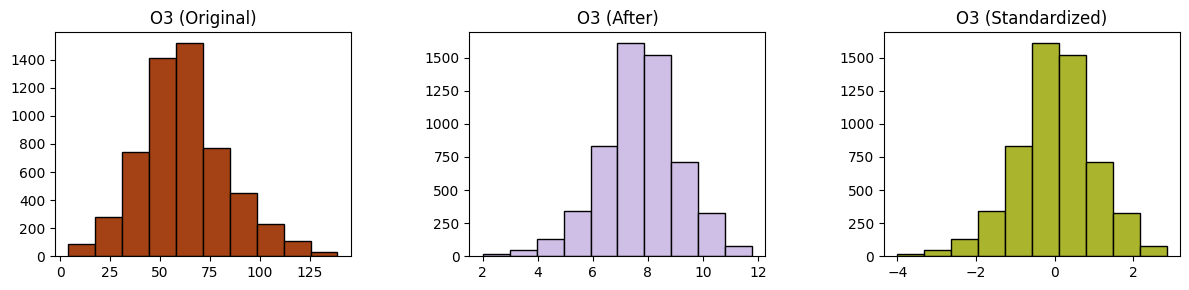

In [28]:
o3 = df['O3'].copy()
o3 = o3 ** (1/2)

scaler = StandardScaler()
standardized_o3 = scaler.fit_transform(o3.values.reshape(-1, 1))

with open('Scalers/scaler_o3.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['O3'],
    o3,
    standardized_o3,
    'O3 (Original)',
    'O3 (After)',
    'O3 (Standardized)'
)

df['O3'] = standardized_o3

**NO2 / PM2.5**

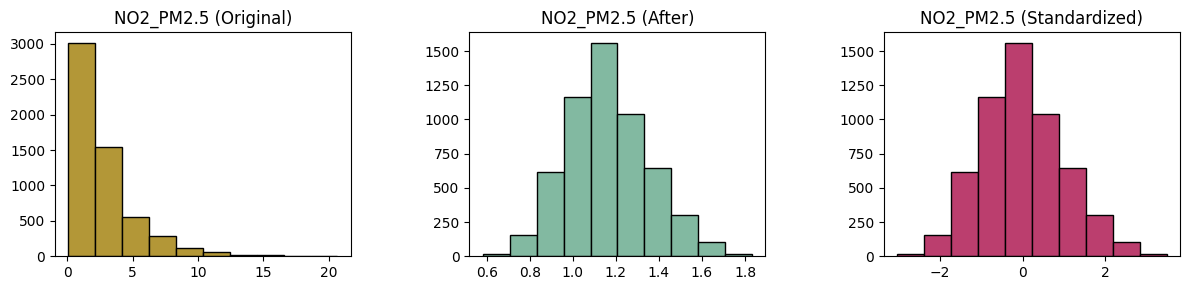

In [41]:
no2_pm25 = df['NO2_PM2.5'].copy()
no2_pm25 = no2_pm25 ** (1/5)

scaler = StandardScaler()
standardized_no2_pm25 = scaler.fit_transform(no2_pm25.values.reshape(-1, 1))

with open('Scalers/scaler_no2_pm25.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['NO2_PM2.5'],
    no2_pm25,
    standardized_no2_pm25,
    'NO2_PM2.5 (Original)',
    'NO2_PM2.5 (After)',
    'NO2_PM2.5 (Standardized)'
)

df['NO2_PM2.5'] = standardized_no2_pm25

**O3 / NO2**

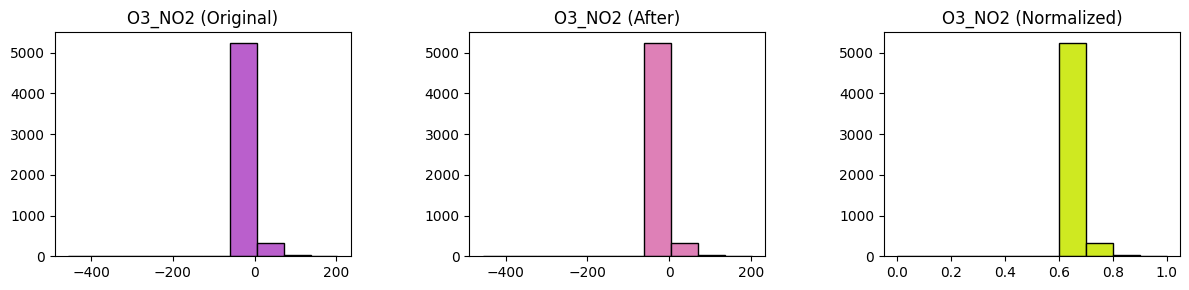

In [44]:
o3_no2 = df['O3_NO2'].copy()

scaler = MinMaxScaler()
normalized_o3_no2 = scaler.fit_transform(o3_no2.values.reshape(-1, 1))

with open('Scalers/scaler_o3_no2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['O3_NO2'],
    o3_no2,
    normalized_o3_no2,
    'O3_NO2 (Original)',
    'O3_NO2 (After)',
    'O3_NO2 (Normalized)'
)

df['O3_NO2'] = normalized_o3_no2

**SO2 / CO2**

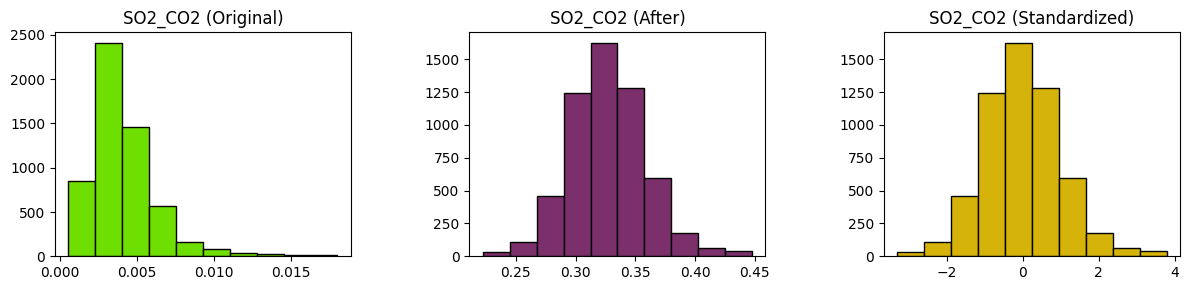

In [51]:
so2_co2 = df['SO2_CO2'].copy()
so2_co2 = so2_co2 ** (1/5)

scaler = StandardScaler()
standardized_so2_co2 = scaler.fit_transform(so2_co2.values.reshape(-1, 1))

with open('Scalers/scaler_so2_co2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

show_compare_histograms(
    df['SO2_CO2'],
    so2_co2,
    standardized_so2_co2,
    'SO2_CO2 (Original)',
    'SO2_CO2 (After)',
    'SO2_CO2 (Standardized)'
)

df['SO2_CO2'] = standardized_so2_co2

In [52]:
df.to_csv('data_with_weather_and_air_normalized.csv', index=False)

In [4]:
df = pd.read_csv('data_with_weather_and_air_normalized.csv')

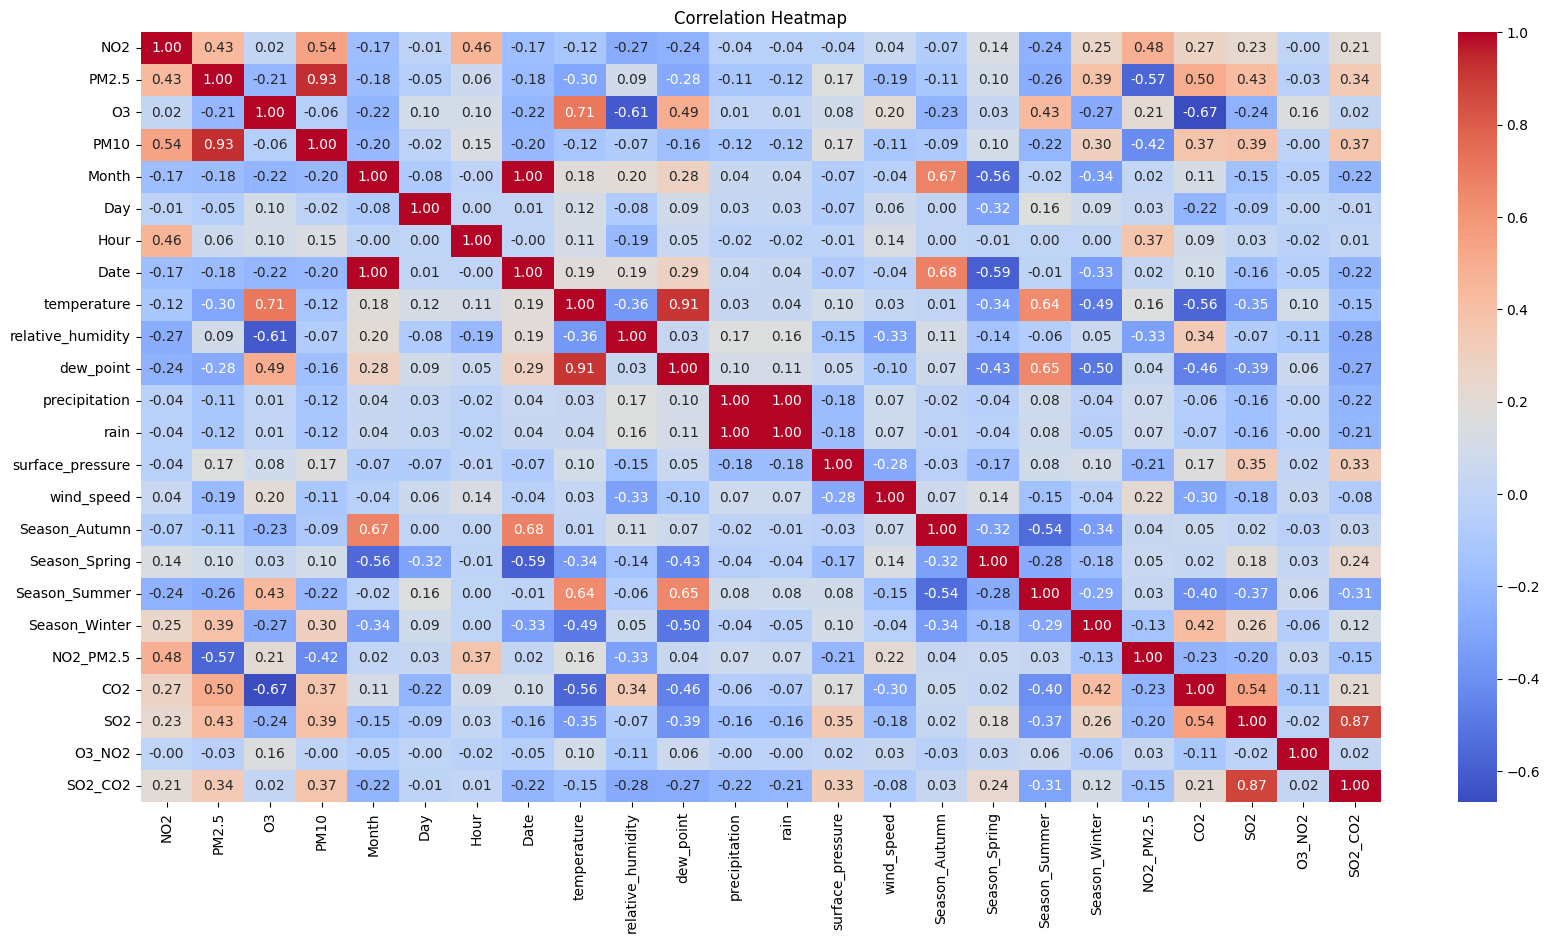

In [375]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [4]:
df = pd.read_csv('data_with_weather_and_air_normalized.csv')

# **Creating Model**

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df_sorted = df.sort_values(by='Date', ascending=True)

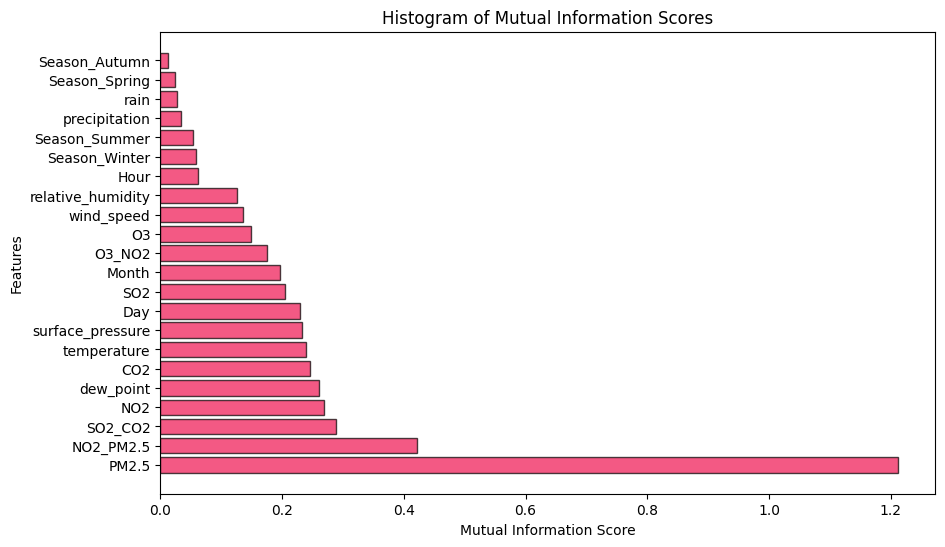

In [8]:
show_mutual_info_scores(df_sorted.drop(['Date'], axis=1))

In [69]:
features = ['PM2.5', 'NO2_PM2.5', 'SO2_CO2', 'O3_NO2', 'dew_point', 'temperature', 'surface_pressure', 'PM10']
X = df_sorted[features]
y = df_sorted['PM10']

print(X.shape)
print(y.shape)

(5625, 8)
(5625,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(X_test.shape)

(4500, 8)
(1125, 8)


In [12]:
def create_sequences(data, window_size, step=1):
    X, y = [], []

    for i in range(0, len(data) - window_size, step):
        X.append(np.array(data.iloc[i:i + window_size]))
        y.append(data.iloc[i + window_size - 1, -1]) # -1 is the last target column (PM10)
    
    return np.array(X), np.array(y)

In [13]:
window_size = 125

X_train, y_train = create_sequences(X_train, window_size)
X_test, y_test = create_sequences(X_test, window_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4375, 125, 8) (4375,)
(1000, 125, 8) (1000,)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], len(features), X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], len(features), X_test.shape[1]))

print("Reshaped X_train:", X_train.shape)
print("Reshaped X_test:", X_test.shape)

input_shape = (len(features), window_size)

Preoblikovani X_train: (4375, 8, 125)
Preoblikovani X_test: (1000, 8, 125)


**RNN model**

In [15]:
model_rnn = Sequential([
    SimpleRNN(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64),
    Dense(64, activation='relu'),
    Dense(1)
])

model_rnn.compile(optimizer=Adam(learning_rate=0.0004), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_rnn = model_rnn.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])


Epoch 1/100

110/110 [==============================] - 4s 12ms/step - loss: 0.4335 - val_loss: 0.3647
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 0.2229 - val_loss: 0.2392
Epoch 3/100
110/110 [==============================] - 1s 7ms/step - loss: 0.1635 - val_loss: 0.1951
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 0.1301 - val_loss: 0.1500
Epoch 5/100
110/110 [==============================] - 1s 7ms/step - loss: 0.1101 - val_loss: 0.1323
Epoch 6/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0914 - val_loss: 0.1124
Epoch 7/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0818 - val_loss: 0.1036
Epoch 8/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0741 - val_loss: 0.0903
Epoch 9/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0631 - val_loss: 0.0876
Epoch 10/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0570 - val

**GRU model**

In [16]:
model_gru = Sequential([
    GRU(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.2), 
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32), 
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=Adam(learning_rate=0.0004), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_gru = model_gru.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
110/110 [==============================] - 7s 19ms/step - loss: 0.3871 - val_loss: 0.1859
Epoch 2/100
110/110 [==============================] - 1s 11ms/step - loss: 0.1187 - val_loss: 0.1013
Epoch 3/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0684 - val_loss: 0.0654
Epoch 4/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0519 - val_loss: 0.0550
Epoch 5/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0402 - val_loss: 0.0406
Epoch 6/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0322 - val_loss: 0.0357
Epoch 7/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0292 - val_loss: 0.0329
Epoch 8/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0256 - val_loss: 0.0305
Epoch 9/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0220 - val_loss: 0.0222
Epoch 10/100
110/110 [==============================] - 1s 11ms/step - loss: 0.022

**LSTM model**

In [17]:
model_lstm = Sequential([
    LSTM(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.0004), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, shuffle=False, callbacks=[early_stopping])

Epoch 1/100
110/110 [==============================] - 8s 24ms/step - loss: 0.9511 - val_loss: 0.8612
Epoch 2/100
110/110 [==============================] - 1s 13ms/step - loss: 0.8513 - val_loss: 0.8334
Epoch 3/100
110/110 [==============================] - 2s 15ms/step - loss: 0.6801 - val_loss: 0.7449
Epoch 4/100
110/110 [==============================] - 2s 14ms/step - loss: 0.5296 - val_loss: 0.5775
Epoch 5/100
110/110 [==============================] - 1s 12ms/step - loss: 0.4045 - val_loss: 0.3893
Epoch 6/100
110/110 [==============================] - 1s 12ms/step - loss: 0.2906 - val_loss: 0.2627
Epoch 7/100
110/110 [==============================] - 1s 13ms/step - loss: 0.2160 - val_loss: 0.2192
Epoch 8/100
110/110 [==============================] - 1s 13ms/step - loss: 0.1575 - val_loss: 0.1687
Epoch 9/100
110/110 [==============================] - 1s 12ms/step - loss: 0.1193 - val_loss: 0.1437
Epoch 10/100
110/110 [==============================] - 1s 13ms/step - loss: 0.094

**Training History**

In [18]:
def show_train_history_plot(history, title):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

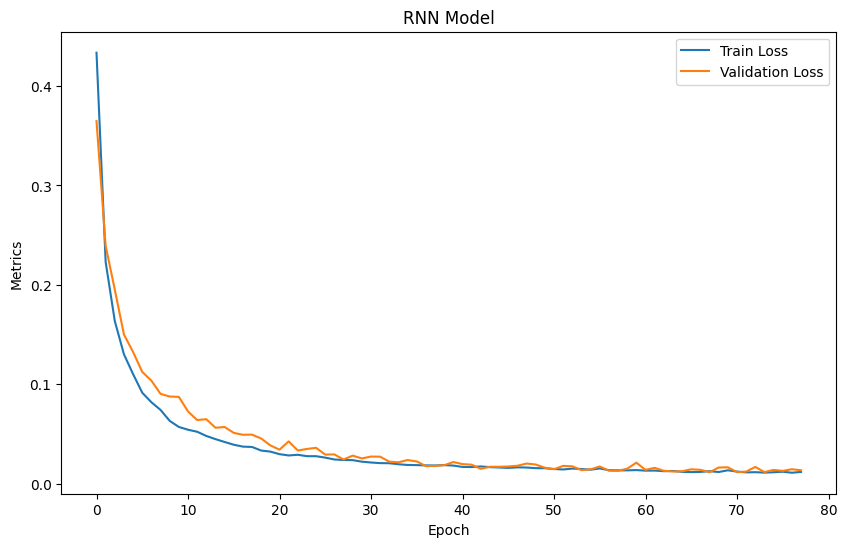

In [19]:
show_train_history_plot(history_rnn, "RNN Model")

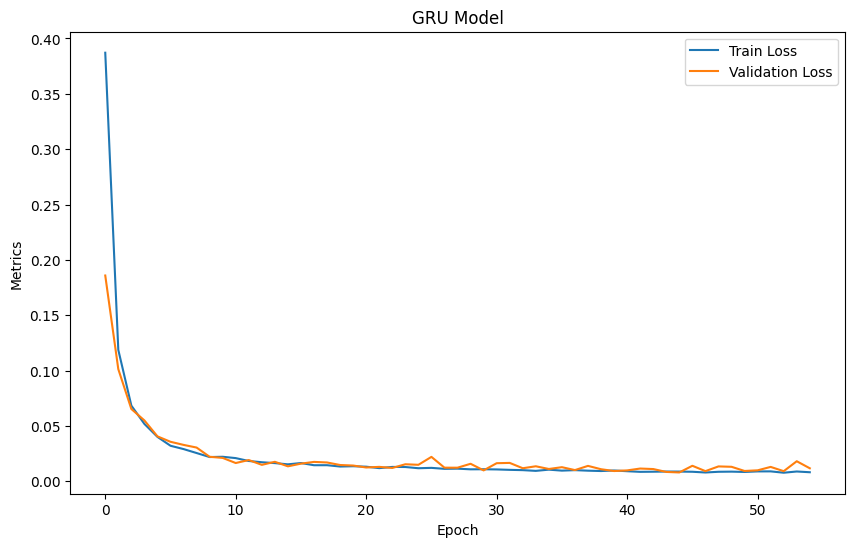

In [20]:
show_train_history_plot(history_gru, "GRU Model")

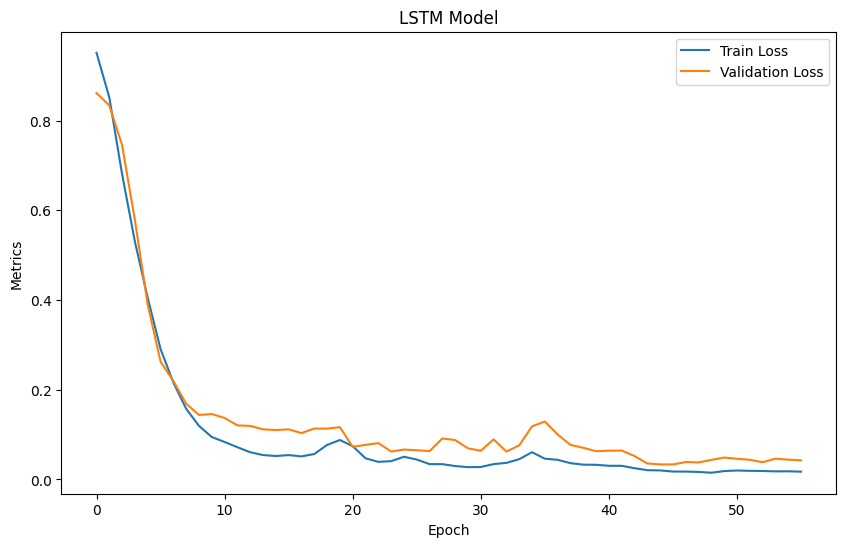

In [21]:
show_train_history_plot(history_lstm, "LSTM Model")

**Predicting & Evaluating**

In [22]:
with open('Scalers/scaler_pm10.pkl', 'rb') as f:
    scaler = pickle.load(f)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_inverse = y_test_inverse ** 5

In [31]:
# RNN
rnn_predictions = model_rnn.predict(X_test)
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions)
rnn_predictions_inverse = rnn_predictions_inverse ** 5

mae = mean_absolute_error(y_test, rnn_predictions)
mse = mean_squared_error(y_test, rnn_predictions)
ev = explained_variance_score(y_test, rnn_predictions)

print("\n*** RNN ***")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"EV: {ev}")

# GRU
gru_predictions = model_gru.predict(X_test)
gru_predictions_inverse = scaler.inverse_transform(gru_predictions)
gru_predictions_inverse = gru_predictions_inverse ** 5

mae = mean_absolute_error(y_test, gru_predictions)
mse = mean_squared_error(y_test, gru_predictions)
ev = explained_variance_score(y_test, gru_predictions)

print("\n*** GRU ***")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"EV: {ev}")

# LSTM
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)
lstm_predictions_inverse = lstm_predictions_inverse ** 5

mae = mean_absolute_error(y_test, lstm_predictions)
mse = mean_squared_error(y_test, lstm_predictions)
ev = explained_variance_score(y_test, lstm_predictions)

print("\n*** LSTM ***")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"EV: {ev}")

32/32 [==============================] - 0s 3ms/step

*** RNN ***
MAE: 0.10149901855055982
MSE: 0.022829697619254047
EV: 0.9784766741050134
32/32 [==============================] - 0s 4ms/step

*** GRU ***
MAE: 0.06692213360451765
MSE: 0.009654081460757828
EV: 0.9916017412249237
32/32 [==============================] - 0s 5ms/step

*** LSTM ***
MAE: 0.13834739146564537
MSE: 0.03228657003121836
EV: 0.9776095776517175


In [32]:
results = pd.DataFrame({
    'Actual Values': y_test_inverse.flatten(), 
    'LSTM Predictions': lstm_predictions_inverse.flatten(),
    'GRU Predictions': gru_predictions_inverse.flatten(),
    'RNN Predictions': rnn_predictions_inverse.flatten()
})
print(results)

     Actual Values  LSTM Predictions  GRU Predictions  RNN Predictions
0             15.0         14.701169        14.763124        13.987806
1             13.0         13.152191        12.790317        12.814403
2             18.0         18.012978        18.179287        17.366957
3             17.0         18.112913        17.533207        16.661560
4             14.0         14.486344        14.344980        14.148602
..             ...               ...              ...              ...
995           19.0         19.319765        18.968515        18.342350
996           20.0         19.868774        19.705013        19.258221
997           16.0         16.193838        16.216343        14.519165
998           13.0         12.975781        13.492410        11.408345
999           11.0         10.066011        10.978869         9.315159

[1000 rows x 4 columns]


**Predictions and actual values plot**

In [33]:
def show_predictions_chart(df, predictions, title, subtitle):
    plt.figure(figsize=(20, 10))
    plt.plot(df['Date'][-len(predictions):], df['PM10'][-len(predictions):], label='Dejanska vrednost')
    plt.plot(df['Date'][-len(predictions):], predictions, label='Napoved')

    plt.xlabel('Čas')
    plt.ylabel('PM10')
    plt.title(subtitle)
    plt.suptitle(title)

    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

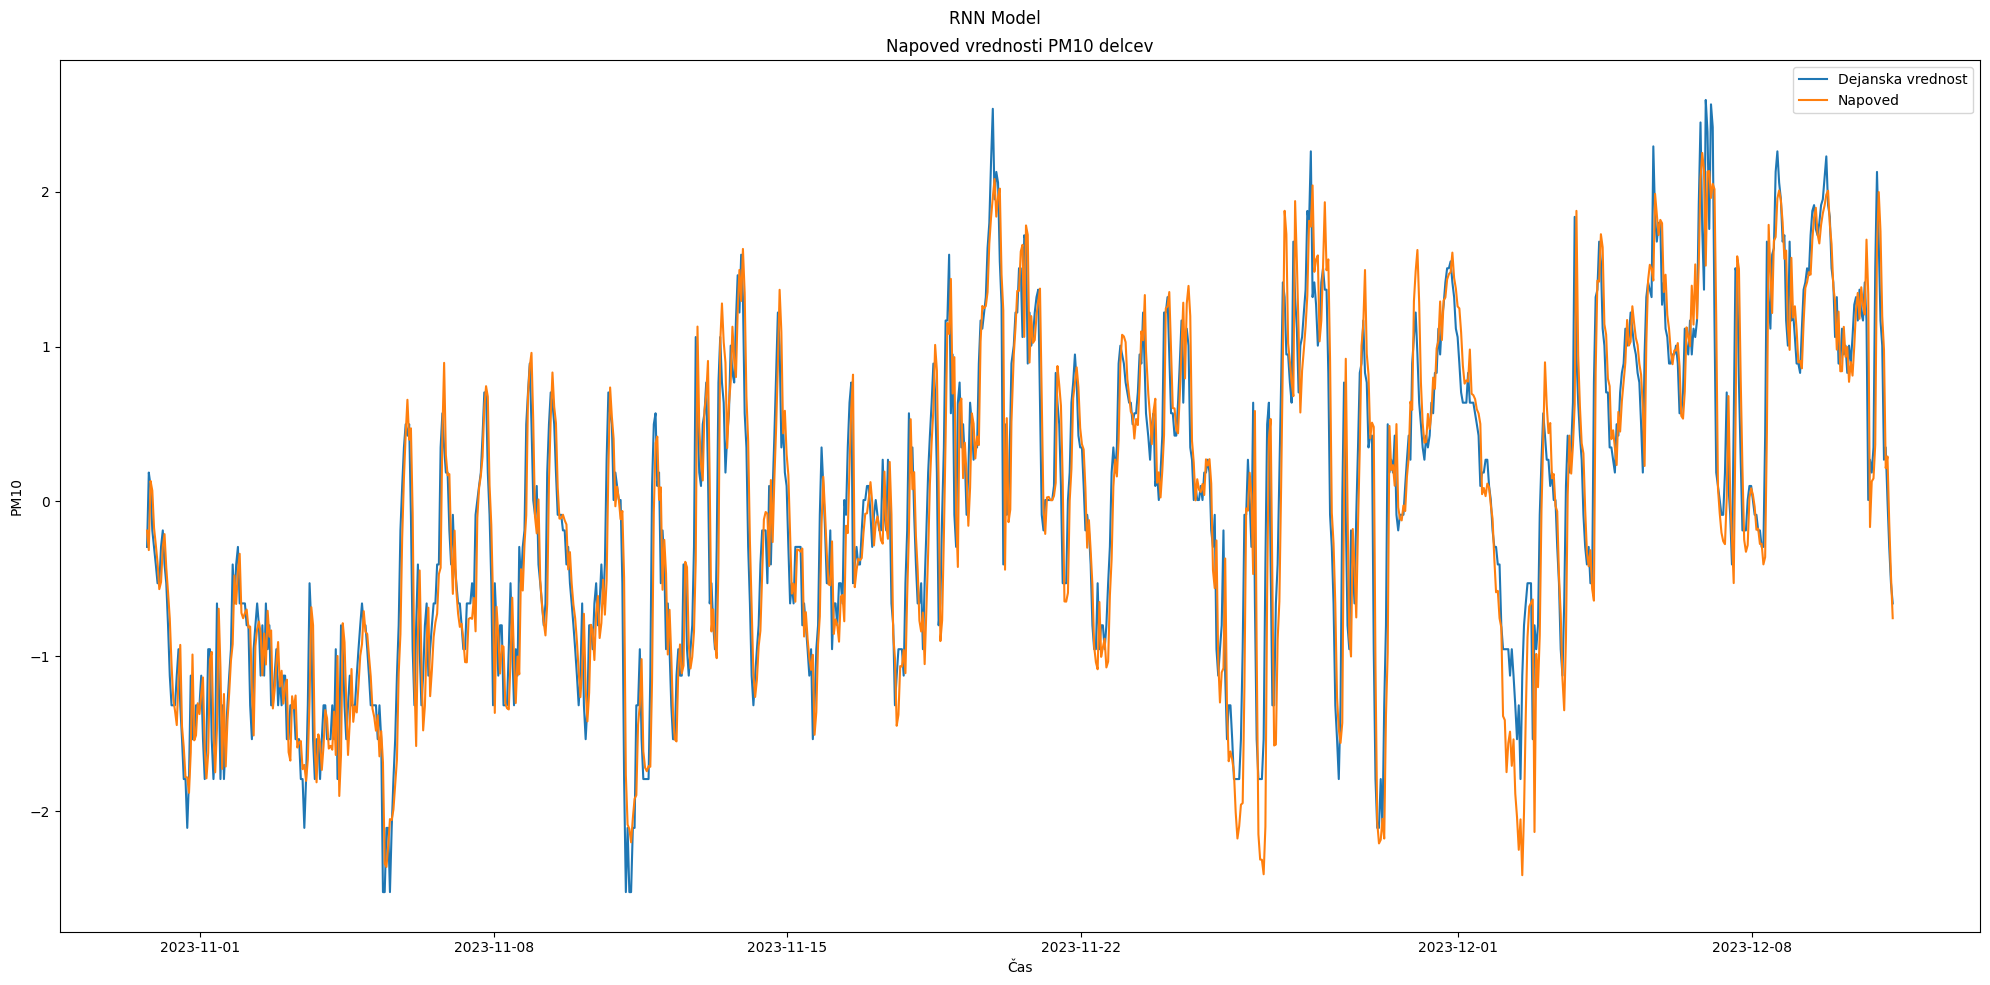

In [34]:
show_predictions_chart(df_sorted, rnn_predictions, "RNN Model", "PM10 Predictions")

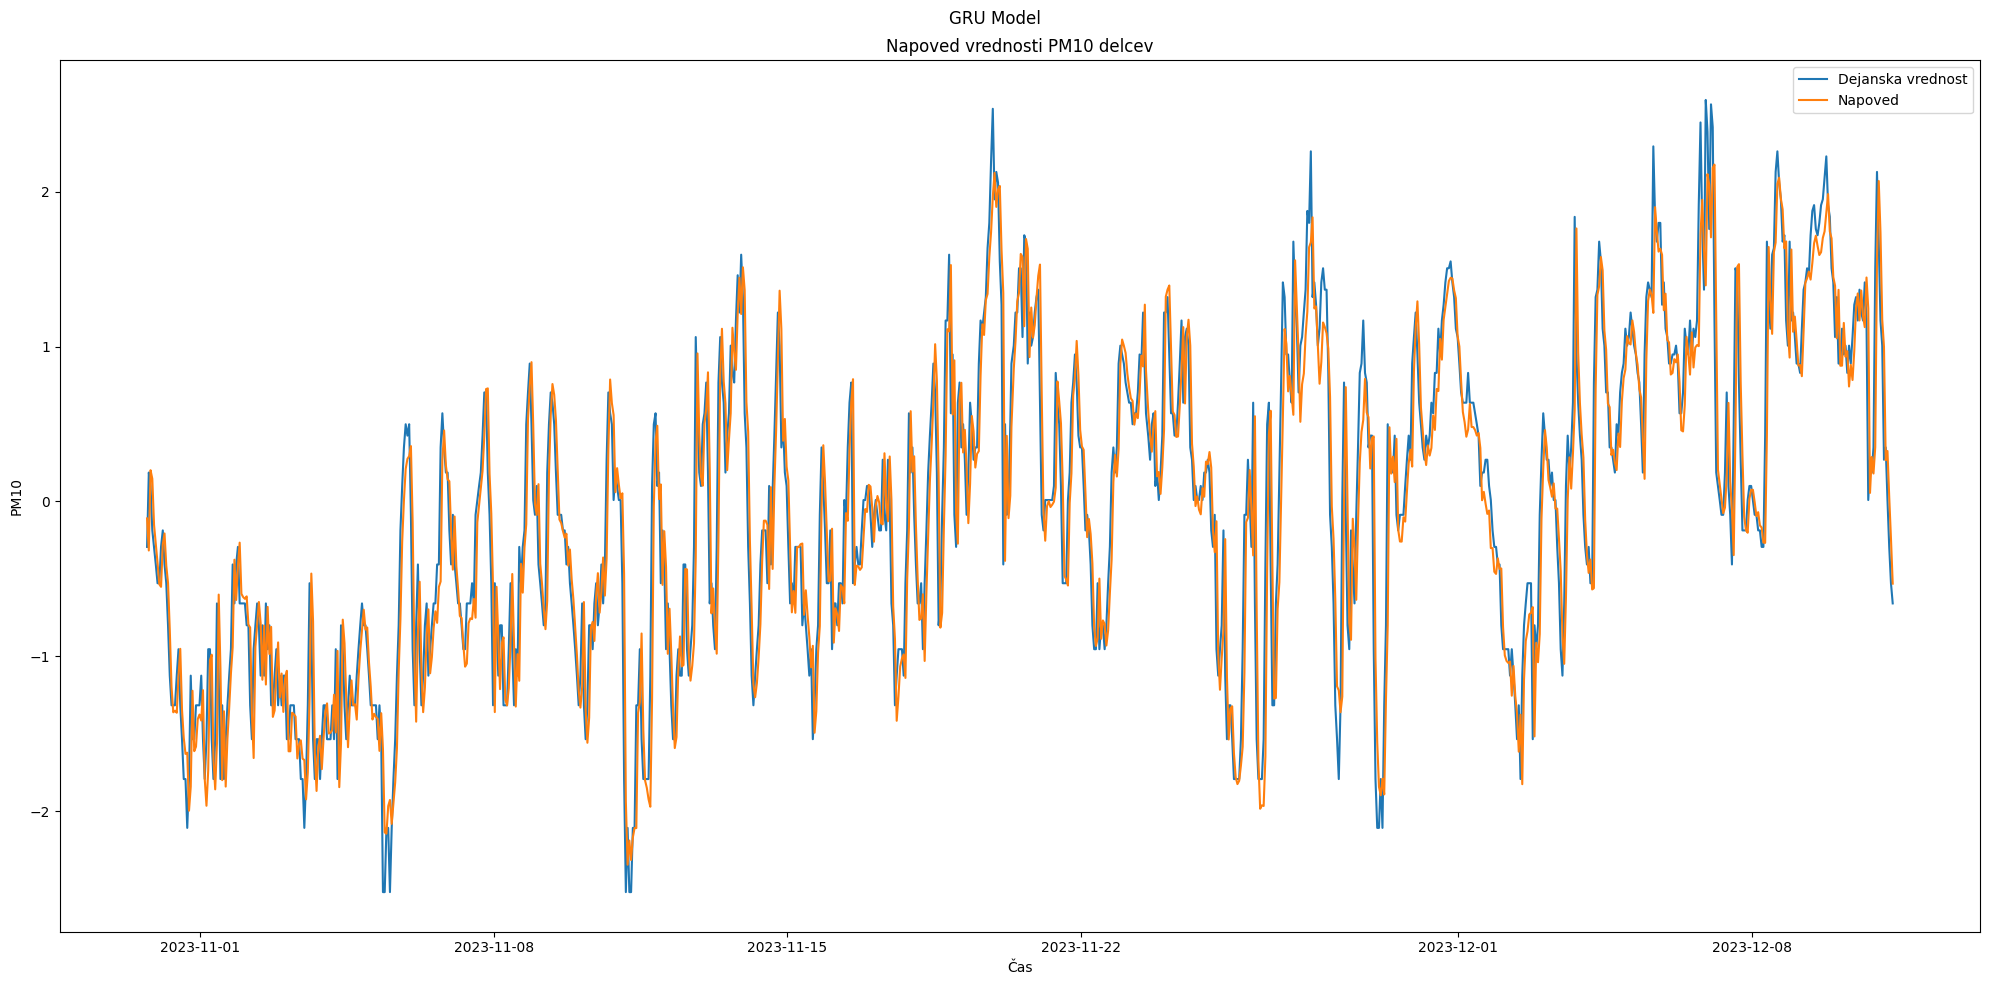

In [35]:
show_predictions_chart(df_sorted, gru_predictions, "GRU Model", "PM10 Predictions")

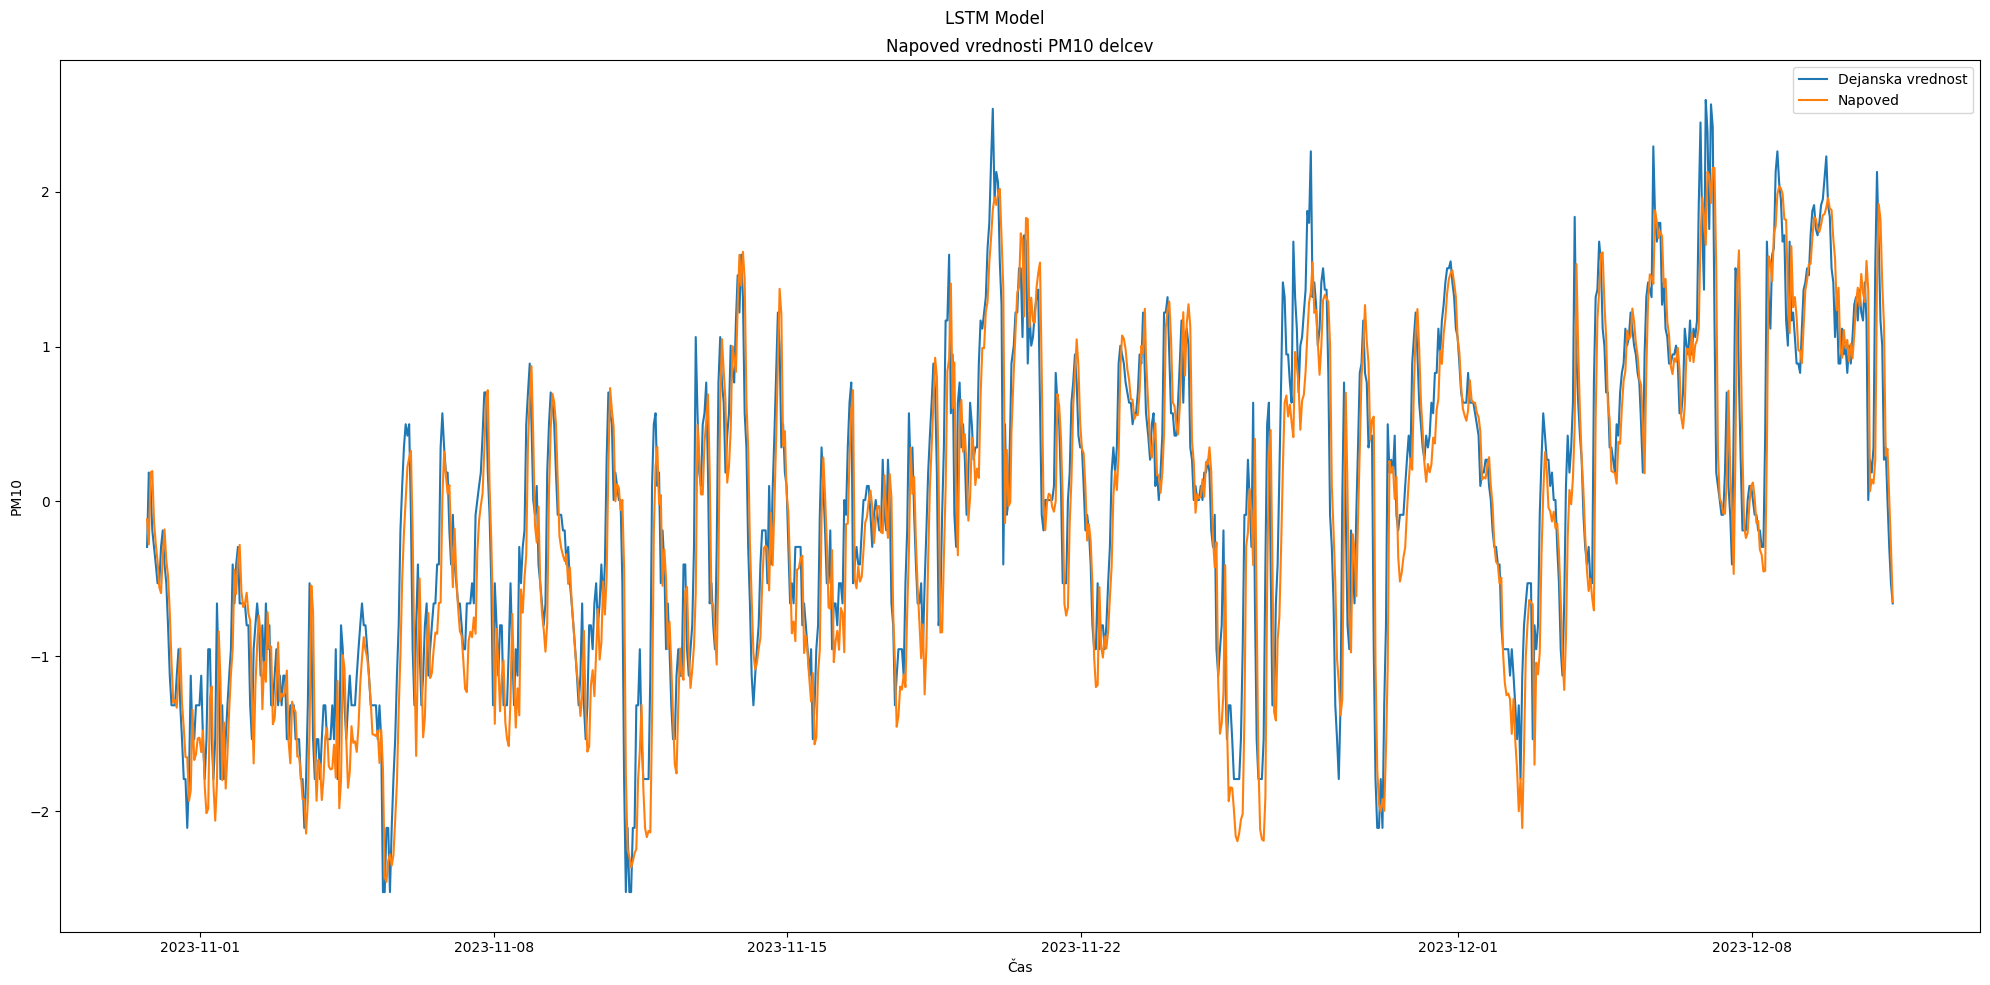

In [36]:
show_predictions_chart(df_sorted, lstm_predictions, "LSTM Model", "PM10 Predictions")

# **Train model on the whole dataset**

In [73]:
X, y = create_sequences(X, window_size)
print(X.shape, y.shape)

X = np.reshape(X, (X.shape[0], len(features), X.shape[1]))
print("Reshaped X:", X.shape)

input_shape = (len(features), window_size)

(5500, 125, 8) (5500,)
Preoblikovani X: (5500, 8, 125)


In [74]:
model_gru = Sequential([
    GRU(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.2), 
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32), 
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=Adam(learning_rate=0.0004), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_gru = model_gru.fit(X, y, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
138/138 [==============================] - 10s 19ms/step - loss: 0.3415 - val_loss: 0.1896
Epoch 2/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0956 - val_loss: 0.0951
Epoch 3/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0591 - val_loss: 0.0645
Epoch 4/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0445 - val_loss: 0.0454
Epoch 5/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0341 - val_loss: 0.0356
Epoch 6/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0283 - val_loss: 0.0237
Epoch 7/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0247 - val_loss: 0.0225
Epoch 8/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0238 - val_loss: 0.0330
Epoch 9/100
138/138 [==============================] - 1s 11ms/step - loss: 0.0202 - val_loss: 0.0174
Epoch 10/100
138/138 [==============================] - 1s 11ms/step - loss: 0.01

# **Save trained models**

In [38]:
model_lstm.save('Models/lstm_model.h5')
model_gru.save('Models/gru_model.h5')
model_rnn.save('Models/rnn_model.h5')

c:\Users\blaz0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_gru.save('Models/gru_model_full.h5')

# **Prepare JSON for testing api**

In [66]:
import json

df_raw = pd.read_csv('data.csv')

df_raw['Date'] = pd.to_datetime(df['Date'])
df_raw = df_raw.sort_values(by='Date', ascending=True)

df_raw = df_raw.iloc[-1000:] # last 1000 rows for test

df_raw['Date'] = df_raw['Date'].astype(str)
max_index = len(df_raw) - window_size

start_index = np.random.randint(0, max_index)
end_index = start_index + window_size

random_window = df_raw.iloc[start_index : end_index]
random_window = random_window.replace({np.nan: 'NaN'})
row_to_predict = df_raw.iloc[end_index + 1]

json_data = random_window.to_dict(orient="records")

with open("Testing/random_sample.json", "w") as json_file:
    json.dump(json_data, json_file, indent=4, default=str)

print("Row to predict:")
print(row_to_predict)

Row to predict:
Date         2023-11-17 23:35:00+00:00
Latitude                       46.5592
Longitude                    15.656191
Altitude                         270.0
NO2                                7.0
PM2.5                              2.0
O3                                   0
PM10                               3.0
Name: 5063, dtype: object
